In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.utils import to_categorical

import cv2

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
cv2_image = cv2.imread("./FER-2013/train/angry/Training_992349.jpg")
print(cv2_image)

[[[ 23  23  23]
  [ 52  52  52]
  [ 54  54  54]
  ...
  [173 173 173]
  [ 98  98  98]
  [ 42  42  42]]

 [[ 23  23  23]
  [ 48  48  48]
  [ 53  53  53]
  ...
  [174 174 174]
  [104 104 104]
  [ 34  34  34]]

 [[ 30  30  30]
  [ 50  50  50]
  [ 55  55  55]
  ...
  [175 175 175]
  [113 113 113]
  [ 36  36  36]]

 ...

 [[ 31  31  31]
  [ 28  28  28]
  [ 29  29  29]
  ...
  [ 54  54  54]
  [ 80  80  80]
  [101 101 101]]

 [[ 31  31  31]
  [ 29  29  29]
  [ 30  30  30]
  ...
  [ 55  55  55]
  [ 80  80  80]
  [ 96  96  96]]

 [[ 29  29  29]
  [ 31  31  31]
  [ 28  28  28]
  ...
  [ 59  59  59]
  [ 79  79  79]
  [ 89  89  89]]]


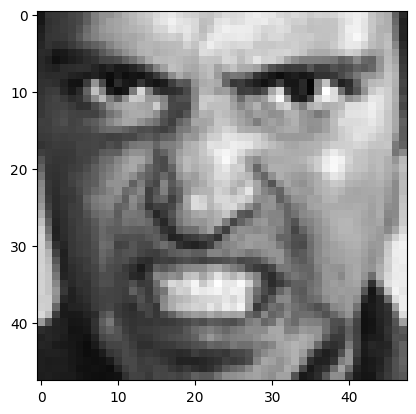

In [5]:
plt.imshow(cv2_image)

In [6]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
BATCH_SIZE = 32

In [8]:
train_generator = train_data_gen.flow_from_directory(
    './FER-2013/train',
    subset='training',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 22968 images belonging to 7 classes.


In [9]:
valid_generator = train_data_gen.flow_from_directory(
    './FER-2013/train',
    subset='validation',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 5741 images belonging to 7 classes.


In [10]:
test_generator = test_data_gen.flow_from_directory(
    './FER-2013/test',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 7178 images belonging to 7 classes.


In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1), padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(filepath='c://Projects/emotion_detect_project/best_model/', monitor='val_loss', mode='min', save_vest_only=True)

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_delta=0.0001)

In [17]:
emotion_model_info = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = 100,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // BATCH_SIZE,
    callbacks=[checkpoint, earlystopping, reduce_lr]
)

Epoch 1/100
714/717 [============================>.] - ETA: 0s - loss: 2.6303 - accuracy: 0.2349

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 24s 26ms/step - loss: 2.6271 - accuracy: 0.2351 - val_loss: 1.7691 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 2/100
717/717 [==============================] - ETA: 0s - loss: 1.7807 - accuracy: 0.2633

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.7807 - accuracy: 0.2633 - val_loss: 1.7609 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 3/100
716/717 [============================>.] - ETA: 0s - loss: 1.7048 - accuracy: 0.3068

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.7047 - accuracy: 0.3069 - val_loss: 1.8175 - val_accuracy: 0.2771 - lr: 0.0010
Epoch 4/100
715/717 [============================>.] - ETA: 0s - loss: 1.6379 - accuracy: 0.3393

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.6382 - accuracy: 0.3392 - val_loss: 1.5955 - val_accuracy: 0.3738 - lr: 0.0010
Epoch 5/100
716/717 [============================>.] - ETA: 0s - loss: 1.5815 - accuracy: 0.3722

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.5812 - accuracy: 0.3725 - val_loss: 1.5194 - val_accuracy: 0.3949 - lr: 0.0010
Epoch 6/100
716/717 [============================>.] - ETA: 0s - loss: 1.5232 - accuracy: 0.4004

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.5227 - accuracy: 0.4008 - val_loss: 1.3940 - val_accuracy: 0.4602 - lr: 0.0010
Epoch 7/100
717/717 [==============================] - ETA: 0s - loss: 1.4719 - accuracy: 0.4207

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 24ms/step - loss: 1.4719 - accuracy: 0.4207 - val_loss: 1.7079 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 8/100
717/717 [==============================] - ETA: 0s - loss: 1.4480 - accuracy: 0.4302

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.4480 - accuracy: 0.4302 - val_loss: 1.3734 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 9/100
717/717 [==============================] - ETA: 0s - loss: 1.4105 - accuracy: 0.4460

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.4105 - accuracy: 0.4460 - val_loss: 1.6068 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 10/100
717/717 [==============================] - ETA: 0s - loss: 1.3816 - accuracy: 0.4622

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.3816 - accuracy: 0.4622 - val_loss: 1.3417 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 11/100
717/717 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.4806

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.3470 - accuracy: 0.4806 - val_loss: 1.4880 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 12/100
717/717 [==============================] - ETA: 0s - loss: 1.3165 - accuracy: 0.4935

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.3165 - accuracy: 0.4935 - val_loss: 1.2768 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 13/100
716/717 [============================>.] - ETA: 0s - loss: 1.2816 - accuracy: 0.5085

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.2819 - accuracy: 0.5082 - val_loss: 1.2460 - val_accuracy: 0.5290 - lr: 0.0010
Epoch 14/100
716/717 [============================>.] - ETA: 0s - loss: 1.2442 - accuracy: 0.5242

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.2442 - accuracy: 0.5242 - val_loss: 1.2479 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 15/100
716/717 [============================>.] - ETA: 0s - loss: 1.2084 - accuracy: 0.5419

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.2080 - accuracy: 0.5421 - val_loss: 1.2329 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 16/100
717/717 [==============================] - ETA: 0s - loss: 1.1579 - accuracy: 0.5592

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.1579 - accuracy: 0.5592 - val_loss: 1.2081 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 17/100
717/717 [==============================] - ETA: 0s - loss: 1.1173 - accuracy: 0.5783

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.1173 - accuracy: 0.5783 - val_loss: 1.2478 - val_accuracy: 0.5585 - lr: 0.0010
Epoch 18/100
717/717 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.5966

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 26ms/step - loss: 1.0629 - accuracy: 0.5966 - val_loss: 1.1976 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 19/100
715/717 [============================>.] - ETA: 0s - loss: 1.0309 - accuracy: 0.6061

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 1.0312 - accuracy: 0.6062 - val_loss: 1.2865 - val_accuracy: 0.5491 - lr: 0.0010
Epoch 20/100
714/717 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.6183

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.9986 - accuracy: 0.6185 - val_loss: 1.2092 - val_accuracy: 0.5669 - lr: 0.0010
Epoch 21/100
717/717 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6405

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.9534 - accuracy: 0.6405 - val_loss: 1.3633 - val_accuracy: 0.5805 - lr: 0.0010
Epoch 22/100
716/717 [============================>.] - ETA: 0s - loss: 0.9050 - accuracy: 0.6592

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.9051 - accuracy: 0.6594 - val_loss: 1.3293 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 23/100
717/717 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6679

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.8781 - accuracy: 0.6679 - val_loss: 1.3352 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 24/100
715/717 [============================>.] - ETA: 0s - loss: 0.8306 - accuracy: 0.6871

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.8312 - accuracy: 0.6869 - val_loss: 1.4787 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 25/100
717/717 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.7023

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.8004 - accuracy: 0.7023 - val_loss: 1.3463 - val_accuracy: 0.5801 - lr: 0.0010
Epoch 26/100
714/717 [============================>.] - ETA: 0s - loss: 0.7542 - accuracy: 0.7129

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.7549 - accuracy: 0.7126 - val_loss: 1.4749 - val_accuracy: 0.5766 - lr: 0.0010
Epoch 27/100
715/717 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.7303

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 17s 24ms/step - loss: 0.7244 - accuracy: 0.7303 - val_loss: 1.3542 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 28/100
716/717 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.7431

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.6856 - accuracy: 0.7431 - val_loss: 1.5314 - val_accuracy: 0.5834 - lr: 0.0010
Epoch 29/100
714/717 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7797

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.5831 - accuracy: 0.7798 - val_loss: 1.5118 - val_accuracy: 0.6020 - lr: 2.0000e-04
Epoch 30/100
716/717 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.7988

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.5321 - accuracy: 0.7989 - val_loss: 1.4806 - val_accuracy: 0.6100 - lr: 2.0000e-04
Epoch 31/100
715/717 [============================>.] - ETA: 0s - loss: 0.4913 - accuracy: 0.8178

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 17s 24ms/step - loss: 0.4914 - accuracy: 0.8178 - val_loss: 1.6274 - val_accuracy: 0.6102 - lr: 2.0000e-04
Epoch 32/100
715/717 [============================>.] - ETA: 0s - loss: 0.4684 - accuracy: 0.8272

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.4679 - accuracy: 0.8273 - val_loss: 1.6485 - val_accuracy: 0.6100 - lr: 2.0000e-04
Epoch 33/100
716/717 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.8318

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 24ms/step - loss: 0.4505 - accuracy: 0.8317 - val_loss: 1.6374 - val_accuracy: 0.6091 - lr: 2.0000e-04
Epoch 34/100
717/717 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.8392

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.4259 - accuracy: 0.8392 - val_loss: 1.6802 - val_accuracy: 0.6114 - lr: 2.0000e-04
Epoch 35/100
716/717 [============================>.] - ETA: 0s - loss: 0.4057 - accuracy: 0.8475

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.4057 - accuracy: 0.8474 - val_loss: 1.8434 - val_accuracy: 0.6152 - lr: 2.0000e-04
Epoch 36/100
717/717 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8563

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.3855 - accuracy: 0.8563 - val_loss: 1.8309 - val_accuracy: 0.6117 - lr: 2.0000e-04
Epoch 37/100
715/717 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8648

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 24ms/step - loss: 0.3698 - accuracy: 0.8648 - val_loss: 1.8822 - val_accuracy: 0.6081 - lr: 2.0000e-04
Epoch 38/100
715/717 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8693

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.3445 - accuracy: 0.8692 - val_loss: 1.9224 - val_accuracy: 0.6082 - lr: 2.0000e-04
Epoch 39/100
717/717 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8833

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.3127 - accuracy: 0.8833 - val_loss: 1.9270 - val_accuracy: 0.6110 - lr: 4.0000e-05
Epoch 40/100
715/717 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8837

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.3132 - accuracy: 0.8836 - val_loss: 1.9610 - val_accuracy: 0.6161 - lr: 4.0000e-05
Epoch 41/100
716/717 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.8833

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.3124 - accuracy: 0.8833 - val_loss: 1.9969 - val_accuracy: 0.6128 - lr: 4.0000e-05
Epoch 42/100
715/717 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8916

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2925 - accuracy: 0.8917 - val_loss: 1.9908 - val_accuracy: 0.6126 - lr: 4.0000e-05
Epoch 43/100
716/717 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8935

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2904 - accuracy: 0.8936 - val_loss: 2.0290 - val_accuracy: 0.6149 - lr: 4.0000e-05
Epoch 44/100
715/717 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8931

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2851 - accuracy: 0.8931 - val_loss: 2.0272 - val_accuracy: 0.6140 - lr: 4.0000e-05
Epoch 45/100
715/717 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.8941

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2842 - accuracy: 0.8942 - val_loss: 2.0745 - val_accuracy: 0.6105 - lr: 4.0000e-05
Epoch 46/100
717/717 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.8984

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2731 - accuracy: 0.8984 - val_loss: 2.0612 - val_accuracy: 0.6133 - lr: 4.0000e-05
Epoch 47/100
715/717 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8982

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 18s 25ms/step - loss: 0.2691 - accuracy: 0.8982 - val_loss: 2.0844 - val_accuracy: 0.6133 - lr: 4.0000e-05
Epoch 48/100
715/717 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.8990

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model\/assets


717/717 [==============================] - 19s 26ms/step - loss: 0.2660 - accuracy: 0.8990 - val_loss: 2.1020 - val_accuracy: 0.6138 - lr: 4.0000e-05


In [21]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = BATCH_SIZE, steps= test_generator.n//BATCH_SIZE)
print(f"accuracy: {test_accuracy*100:.2f}%")
print(f"loss: {test_loss:.2f}")

112/112 [==============================] - 28s 255ms/step - loss: 1.1204 - accuracy: 0.5751
accuracy: 57.51%
loss: 1.12


In [22]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

113/113 [==============================] - 4s 33ms/step


In [21]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [22]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       958
     disgust       0.03      0.02      0.02       111
        fear       0.14      0.12      0.13      1024
       happy       0.25      0.31      0.28      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.17      0.13      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178

